<a href="https://colab.research.google.com/github/Krumpu/Homework_ICA/blob/main/HW_2_ICA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Preparação Dos Dados


*   ### ETAPA 1
Irei dropar BOD e manter COD para a regressão

Outcome = COD

Preditoers = avg_outflow,	avg_inflow,	total_grid,	Am,	COD,	TN,	T,	TM,	Tm,	SLP,	H,	PP,	VV,	V,	VM,	VG   (15) no total

Número de observações: 1382
*   ### ETAPA 2
Separar o dataset de treino e de teste

Visualizar assimetria, e aplicar tratamento para assimetria em valores com assimetria que não estejam entre -1 1  

Normalizar os dados que estão em escalas muito diferentes do resto


* ### ETAPA 3

aplicar OLS nos dados normalizados
$$\beta = (X^T X)^{-1} X^T y$$

Previsão com base no beta obtido
$\hat{y} = X \cdot \beta$

Calcular RMSE
$\sqrt{\frac{1}{N} \sum (y_{real} - y_{pred})^2}$\
Calcular R^2
 $1 - \frac{\text{Soma dos Erros Quadráticos}}{\text{Soma da Variância Total}}$

* ### Etapa 4 Ridge

$$\beta = (X^T X + \lambda I)^{-1} X^T y$$

In [89]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [90]:
url = 'https://raw.githubusercontent.com/Krumpu/Homework_ICA/main/Data-Melbourne_F.csv'
df = pd.read_csv(url)
df = df.drop(columns=['BOD','month', 'day','year'])
df
df_y = df[['COD']].copy()
df_x = df.drop(columns=['COD'])

In [91]:
df_y

,COD
0,730.0
1,740.0
2,836.0
3,850.0
4,1016.0
...,...
1377,660.0
1378,700.0
1379,860.0
1380,900.0


In [92]:
df_x

,avg_outflow,avg_inflow,total_grid,Am,TN,T,TM,Tm,SLP,H,PP,VV,V,VM,VG
0,2.941,2.589,175856,27.0,60.378,19.3,25.1,12.6,0.0,56,1.52,10.0,26.9,53.5,79.5
1,2.936,2.961,181624,25.0,60.026,17.1,23.6,12.3,0.0,63,0.00,10.0,14.4,27.8,0.0
2,2.928,3.225,202016,42.0,64.522,16.8,27.2,8.8,0.0,47,0.25,10.0,31.9,61.1,77.8
3,2.928,3.354,207547,36.0,63.000,14.6,19.9,11.1,0.0,49,0.00,10.0,27.0,38.9,53.5
4,2.917,3.794,202824,46.0,65.590,13.4,19.1,8.0,0.0,65,0.00,10.0,20.6,35.2,53.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,5.068,4.716,305938,28.0,58.807,6.8,10.0,4.0,0.0,56,0.00,10.0,14.4,22.2,0.0
1378,5.882,5.510,293446,40.0,60.671,7.6,16.0,3.0,0.0,71,0.00,0.0,13.5,25.9,0.0
1379,4.638,4.811,307968,47.0,64.000,9.7,16.0,3.0,0.0,65,0.00,10.0,18.1,25.9,0.0
1380,5.373,4.929,316675,46.0,62.479,10.9,17.0,5.0,0.0,65,0.00,10.0,21.9,35.2,51.9


In [93]:

treino_x, teste_x, treino_y, teste_y = train_test_split(df_x,df_y,
                                                        test_size=0.2,
                                                        random_state=42,
                                                        shuffle=True)

In [94]:
assimetria = df.drop('COD', axis=1).skew()
print("--- Assimetria das Variáveis ---")
print(assimetria.sort_values(ascending=False))

--- Assimetria das Variáveis ---
VV             22.195410
SLP            16.553264
PP              8.763062
avg_inflow      3.751865
V               0.833200
VM              0.552547
T               0.552359
Tm              0.498749
TM              0.485291
avg_outflow     0.380545
Am              0.310626
VG              0.286864
total_grid     -0.148416
TN             -0.256672
H              -0.809744
dtype: float64


Os valores de assimetria que fogem do intervalo de -1 a 1 estão acima de 1 portanto iremos usar logaritmo para diminuir os valores que são muito maiores.

In [95]:
colunas_assimetricas =  ['VV', 'SLP', 'PP', 'avg_inflow']

for colunas in colunas_assimetricas:
  treino_x[colunas] = np.log1p(treino_x[colunas])
  teste_x[colunas] = np.log1p(teste_x[colunas])

In [96]:
assimetria = treino_x.skew()
print("--- Assimetria das Variáveis ---")
print(assimetria.sort_values(ascending=False))

--- Assimetria das Variáveis ---
SLP            16.552872
PP              5.546905
avg_inflow      1.839270
V               0.841922
T               0.542608
VM              0.517327
Tm              0.506219
TM              0.486119
avg_outflow     0.334408
VG              0.279784
Am              0.009186
TN              0.001491
total_grid     -0.127093
H              -0.855612
VV             -0.941220
dtype: float64


OLS APOS O TRATAMENTO DE ASSIMETRIA


In [97]:
def OLS_manual(treino_x, treino_y, teste_x, teste_y):

    media_treino = np.mean(treino_x, axis=0)
    std_treino = np.std(treino_x, axis=0)
    std_treino[ std_treino == 0 ] = 1.0
    treino_x_escalado = (treino_x - media_treino) / std_treino
    teste_x_escalado  = (teste_x - media_treino) / std_treino

    #Coluna para o bias, somente 1's por enquanto
    uns_treino = np.ones((treino_x_escalado.shape[0], 1))
    X_treino_bias = np.c_[uns_treino, treino_x_escalado]

    #Transposa de X
    x_transposto = X_treino_bias.T
    #Transposta de X * X
    xT_x = x_transposto @ X_treino_bias
    #Inversa
    try:
        xT_x_inv = np.linalg.inv(xT_x)
    except:
        xT_x_inv = np.linalg.pinv(xT_x)

    xT_y = x_transposto @ treino_y

    beta = xT_x_inv @ xT_y

    teste_bias = np.ones((teste_x_escalado.shape[0],1))
    teste_x_bias = np.c_[teste_bias, teste_x_escalado]
    predicao_ols_y = teste_x_bias @ beta

    erros = teste_y.reshape(-1, 1) - predicao_ols_y
    erros_quadrados = erros ** 2
    mse = np.mean(erros_quadrados)
    rmse_manual = np.sqrt(mse)

    ss_res = np.sum(erros_quadrados)
    media_y_real = np.mean(teste_y)
    ss_tot = np.sum((teste_y.reshape(-1, 1) - media_y_real) ** 2)
    r2_manual = 1 - (ss_res / ss_tot)

    return rmse_manual, r2_manual, predicao_ols_y

In [98]:
def OLS_cross_val(X,y,k):

        n = len(X)
        indices = np.arange(n) #Deixar aleatorio os valores que estaram em cada fold
        np.random.seed(77) # "aleatorio", padrão fixo pra não alterar o resultado toda vez que rodarmos no collab
        np.random.shuffle(indices)

        tam_fold  = n // k
        rmse_scores = []
        r2_scores = []

        print(f"Cross Validation com k igual à {k}")

        for i in range (k):
            #Linhas para pegar cada intervalo
            inicio = i * tam_fold

            if i == k-1:
                  fim = n
            else:
                 fim = (i+1) * tam_fold

            ind_val = indices[int(inicio):int(fim)]
            ind_treino = np.concatenate([indices[:int(inicio)], indices[int(fim):]])

            treino_x_f = X[ind_treino]
            treino_y_f = y[ind_treino]
            val_x_f = X[ind_val]
            val_y_f = y[ind_val]

            media_fold = np.mean(treino_x_f,axis=0)
            std_fold = np.std(treino_x_f, axis=0)
            std_fold[std_fold == 0] = 1.0

            treino_x_norm = (treino_x_f - media_fold) / std_fold
            X_val_norm   = (val_x_f - media_fold) / std_fold

            treino_x_bias = np.c_[np.ones((len(treino_x_norm), 1)), treino_x_norm]
            X_val_bias   = np.c_[np.ones((len(X_val_norm), 1)), X_val_norm]

            xt_x = treino_x_bias.T @ treino_x_bias
            xt_y = treino_x_bias.T @ treino_y_f

            beta_fold = np.linalg.inv(xt_x) @ xt_y

            # Métricas
            y_pred = X_val_bias @ beta_fold
            erro = val_y_f - y_pred

            rmse_scores.append(np.sqrt(np.mean(erro**2)))

            ss_res = np.sum(erro**2)
            ss_tot = np.sum((val_y_f - np.mean(val_y_f))**2)
            r2_scores.append(1 - (ss_res / ss_tot))

        return np.mean(rmse_scores), np.mean(r2_scores)

In [99]:
rmse_manual, r2_manual, predicao_ols_y = OLS_manual(treino_x.values,  treino_y.values,  teste_x.values, teste_y.values)
print(f"RMSE : {rmse_manual:.4f}")
print(f"R²:   {r2_manual:.4f}")
df_resultados = pd.DataFrame({
    'COD_Real': np.array(teste_y).flatten(),
    'COD_Previsto': predicao_ols_y.flatten()
}, index=teste_y.index)
df_resultados['Erro_Absoluto'] = df_resultados['COD_Real'] - df_resultados['COD_Previsto']
df_resultados

RMSE : 92.7958
R²:   0.5339


,COD_Real,COD_Previsto,Erro_Absoluto
309,855.0,704.249923,150.750077
741,930.0,871.491015,58.508985
265,875.0,870.836369,4.163631
823,880.0,884.280653,-4.280653
778,1000.0,782.067707,217.932293
...,...,...,...
724,770.0,800.726149,-30.726149
374,1042.0,894.137246,147.862754
964,1000.0,874.332577,125.667423
923,800.0,868.544011,-68.544011


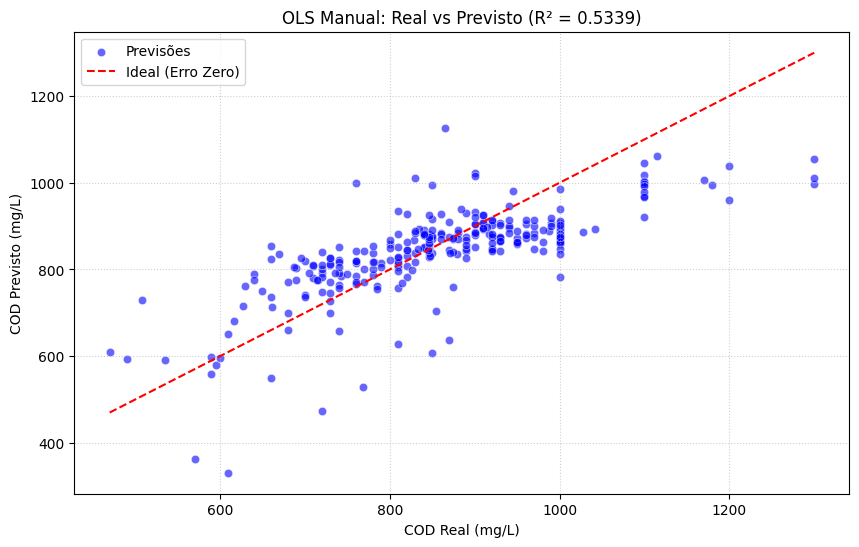

In [100]:

plt.figure(figsize=(10, 6))
sns.scatterplot(x='COD_Real', y='COD_Previsto', data=df_resultados, alpha=0.6, color='blue', label='Previsões')
min_val = df_resultados['COD_Real'].min()
max_val = df_resultados['COD_Real'].max()
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal (Erro Zero)')

plt.title(f'OLS Manual: Real vs Previsto (R² = {r2_manual:.4f})')
plt.xlabel('COD Real (mg/L)')
plt.ylabel('COD Previsto (mg/L)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)

plt.show()

In [101]:
media_rmse, media_r2 = OLS_cross_val(treino_x.values, treino_y.values, k=5)
print(f"Média RMSE (CV): {media_rmse:.4f}")
print(f"Média R² (CV):   {media_r2:.4f}")


Cross Validation com k igual à 5
Média RMSE (CV): 107.3403
Média R² (CV):   0.4652


RIDGE praticamente a mesma coisa de OLS diferença a presença de penalidade


In [102]:
def ridge_solver(X_bias, y, lambda_val):

    n_colunas = X_bias.shape[1]
    identidade = np.eye(n_colunas)
    identidade[0, 0] = 0.0

    xt_x = X_bias.T @ X_bias
    penalidade = lambda_val * identidade

    try:
        inversa = np.linalg.inv(xt_x + penalidade)
    except:
        inversa = np.linalg.pinv(xt_x + penalidade)

    beta = inversa @ (X_bias.T @ y)
    return beta

In [103]:
def ridge_manual(treino_x, treino_y, teste_x, teste_y, lambda_val):



    #Mesma preparação feita no OLS, deixar todos na mesma escala e adicionar a coluna
    #de Bias
    media_treino = np.mean(treino_x, axis=0)
    std_treino = np.std(treino_x, axis=0)
    std_treino[std_treino == 0] = 1.0
    treino_x_escalado = (treino_x - media_treino) / std_treino
    teste_x_escalado  = (teste_x - media_treino) / std_treino
    uns_treino = np.ones((treino_x_escalado.shape[0], 1))
    X_treino_bias = np.c_[uns_treino, treino_x_escalado]
    uns_teste = np.ones((teste_x_escalado.shape[0], 1))
    teste_x_bias = np.c_[uns_teste, teste_x_escalado]


    # beta = (X^T * X + lambda * I)^-1 * X^T * y

    n_colunas = X_treino_bias.shape[1]
    identidade = np.eye(n_colunas)
    identidade[0, 0] = 0.0


    beta = ridge_solver(X_treino_bias, treino_y, lambda_val)

    predicao_ridge_y = teste_x_bias @ beta

    erros = teste_y.reshape(-1, 1) - predicao_ridge_y
    erros_quadrados = erros ** 2

    mse = np.mean(erros_quadrados)
    rmse_manual = np.sqrt(mse)

    ss_res = np.sum(erros_quadrados)
    media_y_real = np.mean(teste_y)
    ss_tot = np.sum((teste_y.reshape(-1, 1) - media_y_real) ** 2)
    r2_manual = 1 - (ss_res / ss_tot)

    # Pegar o escalar
    val_r2 = r2_manual.item() if hasattr(r2_manual, 'item') else r2_manual

    return rmse_manual, val_r2, predicao_ridge_y

In [104]:
def ridge_cross_validation(X, y, lambda_val, k=5):

    #Usei a mesma seed que o ols
    n_samples = len(X)
    indices = np.arange(n_samples)
    np.random.seed(77)
    np.random.shuffle(indices)

    fold_size = n_samples // k
    rmse_scores = []
    r2_scores = []

    for i in range(k):
        # divisão dos folds
        start = i * fold_size
        if i == k - 1:
            end = n_samples
        else:
            end = (i + 1) * fold_size

        idx_val = indices[start:end]
        idx_train = np.concatenate([indices[:start], indices[end:]])

        X_f_train, y_f_train = X[idx_train], y[idx_train]
        X_f_val, y_f_val     = X[idx_val], y[idx_val]

        # Validação feita com base no fold e não no treino inteiro
        media_fold = np.mean(X_f_train, axis=0)
        std_fold = np.std(X_f_train, axis=0)
        std_fold[std_fold == 0] = 1.0

        X_train_norm = (X_f_train - media_fold) / std_fold
        X_val_norm   = (X_f_val - media_fold) / std_fold

        X_train_bias = np.c_[np.ones((len(X_train_norm), 1)), X_train_norm]
        X_val_bias   = np.c_[np.ones((len(X_val_norm), 1)), X_val_norm]

        beta = ridge_solver(X_train_bias, y_f_train, lambda_val)

        y_pred = X_val_bias @ beta

        erro = y_f_val - y_pred
        rmse_scores.append(np.sqrt(np.mean(erro**2)))

        ss_res = np.sum(erro**2)
        ss_tot = np.sum((y_f_val - np.mean(y_f_val))**2)
        r2_scores.append(1 - (ss_res / ss_tot))

    return np.mean(rmse_scores), np.mean(r2_scores)

In [110]:
lambdas_teste = [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]

rmse_medios = []

print("Cross_variation")

# Loop de Validação
for lam in lambdas_teste:
    rmse_cv, _ = ridge_cross_validation(treino_x.values, treino_y.values, lambda_val=lam, k=5)

    rmse_medios.append(rmse_cv)
    print(f"Lambda {lam}: RMSE Médio CV = {rmse_cv:.4f}")

#Escolher o Melhor
melhor_idx = np.argmin(rmse_medios)
melhor_lambda = lambdas_teste[melhor_idx]

print(f"\nvencedor: Lambda = {melhor_lambda}")
print(f"menor RMSE (CV): {rmse_medios[melhor_idx]:.4f}")


print(f"\nModelo Final com Lambda {melhor_lambda}")

rmse_final, r2_final, pred_ridge = ridge_manual(
    treino_x.values,
    treino_y.values,
    teste_x.values,
    teste_y.values,
    lambda_val=melhor_lambda
)

print(f"RMSE Final (Teste): {rmse_final:.4f}")
print(f"R² Final (Teste):   {r2_final:.4f}")

Cross_variation
Lambda 0.001: RMSE Médio CV = 107.3403
Lambda 0.01: RMSE Médio CV = 107.3402
Lambda 0.1: RMSE Médio CV = 107.3392
Lambda 0.5: RMSE Médio CV = 107.3348
Lambda 1: RMSE Médio CV = 107.3294
Lambda 5: RMSE Médio CV = 107.2903
Lambda 10: RMSE Médio CV = 107.2500
Lambda 50: RMSE Médio CV = 107.1393
Lambda 100: RMSE Médio CV = 107.3238
Lambda 500: RMSE Médio CV = 112.4486
Lambda 1000: RMSE Médio CV = 118.7715

vencedor: Lambda = 50
menor RMSE (CV): 107.1393

Modelo Final com Lambda 50
RMSE Final (Teste): 92.7912
R² Final (Teste):   0.5340
